In [1]:
import networkx as nx

from networkx.generators.community import LFR_benchmark_graph

import matplotlib
import matplotlib.pyplot as plt

from pyspark.ml.clustering import KMeans

from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors


from sklearn.metrics import normalized_mutual_info_score
from clusim.clustering import Clustering
import clusim.sim as sim

In [2]:
n = 1000
tau1 = 2  # Power-law exponent for the degree distribution
tau2 = 1.1 # Power-law exponent for the community size distribution 
            #S hould be >1
mu = 0.1 # Mixing parameter

G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=25, max_degree=100, min_community=50, max_community=100, 
    seed=2
)

In [3]:
G = nx.Graph(G) # Remove multi-edges

selfloop_edges = list(nx.selfloop_edges(G)) # a list of self loops

G.remove_edges_from(selfloop_edges) # Remove self-loops

In [4]:
# Get the intrinsic community structure as a list
intrinsic_communities = {frozenset(G.nodes[v]["community"]) for v in G}
intrinsic_membership = {}
for node in range(G.number_of_nodes()):
    for index, inner_set in enumerate(intrinsic_communities):
        if node in inner_set:
            intrinsic_membership[node] = index
            break

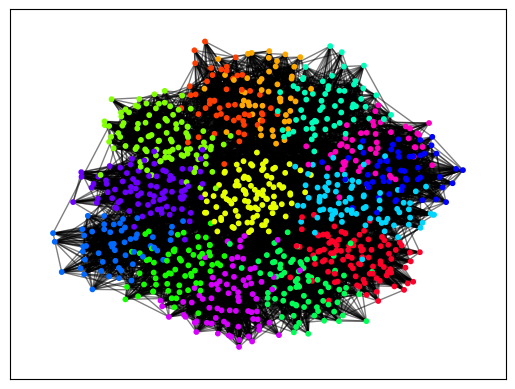

In [5]:
#import matplotlib
#import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,
                      pos,
                      #intrinsic_membership.keys(),
                      node_size=10,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=list(intrinsic_membership.values())
                      )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [6]:
intrinsic_clustering = Clustering(elm2clu_dict={i: [intrinsic_membership[i]] for i in intrinsic_membership.keys()})

In [7]:
import warnings

# Suppress UserWarning in the next cell
warnings.filterwarnings("ignore", category=UserWarning)

In [9]:
from ge import LINE
#for D in range(15,990,5):
for D in range(60,61): 
    model = LINE(G,embedding_size=D,order='first');
    model.train(batch_size=1024,epochs=50,verbose=0);# train model
    LINE_embd = model.get_embeddings();# get embedding vectors

    LINE_vec = [Vectors.dense(LINE_embd[i]) for i in range(len(LINE_embd))]
    LINE_prep = SparkSession.builder.getOrCreate().\
                        createDataFrame([(vector,) for vector in LINE_vec], ["embd"])

    euclid_kmeans = KMeans(k=14, featuresCol="embd")
    cosine_kmeans = KMeans(k=14, featuresCol="embd", distanceMeasure="cosine")
    LINE_euclid_model = euclid_kmeans.fit(LINE_prep)
    LINE_cosine_model = cosine_kmeans.fit(LINE_prep)

    # Add the cluster assignment to the DataFrame
    LINE_euclid = LINE_euclid_model.transform(LINE_prep)
    LINE_cosine = LINE_cosine_model.transform(LINE_prep)

    # Extract the cluster assignment and convert it to a list
    LINE_euclid_membership = LINE_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
    LINE_cosine_membership = LINE_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()
    #print(max(LINE_euclid_membership)+1, max(LINE_cosine_membership)+1)

    # Calculate the NMI
    LINE_euclid_nmi = normalized_mutual_info_score(list(LINE_euclid_membership), list(intrinsic_membership.values()))
    LINE_cosine_nmi = normalized_mutual_info_score(list(LINE_cosine_membership), list(intrinsic_membership.values()))

    print(f"{D}-dimensional NMIs:", LINE_euclid_nmi, LINE_cosine_nmi)

    LINE_euclid_clustering = Clustering(elm2clu_dict={i: [LINE_euclid_membership[i]] for i in range(len(LINE_euclid_membership))})
    LINE_cosine_clustering = Clustering(elm2clu_dict={i: [LINE_cosine_membership[i]] for i in range(len(LINE_cosine_membership))})

    LINE_euclid_similarity = sim.element_sim(intrinsic_clustering, LINE_euclid_clustering, alpha=0.9)
    LINE_cosine_similarity = sim.element_sim(intrinsic_clustering, LINE_cosine_clustering, alpha=0.9)

    print(f"{D}-dimensional ECSim:", LINE_euclid_similarity, LINE_cosine_similarity)

2023-06-18 11:49:26.240050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60-dimensional NMIs: 0.956464930155114 0.9740557793736647
60-dimensional ECSim: 0.861992609922757 0.9054776470588235
